In [1]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances(
    "TRAIN_DATASET",
    {},
    "/home/coder/data/trong/KLTN/data_drill_3/anno_train/_annotations_filtered.coco.json",
    "/home/coder/data/trong/KLTN/data_drill_3/train",
)
register_coco_instances(
    "VAL_DATASET",
    {},
    "/home/coder/data/trong/KLTN/data_drill_3/anno_valid/_annotations_filtered.coco.json",
    "/home/coder/data/trong/KLTN/data_drill_3/valid",
)
register_coco_instances(
    "TEST_DATASET",
    {},
    "/home/coder/data/trong/KLTN/data_drill_3/anno_test/_annotations_filtered.coco.json",
    "/home/coder/data/trong/KLTN/data_drill_3/test",
)

In [ ]:
# def unregister(name: str):
#     # gỡ dataset
#     if name in DatasetCatalog.list():
#         try:
#             DatasetCatalog.remove(name)           # Detectron2 mới
#         except AttributeError:
#             # với Detectron2 cũ: dễ nhất vẫn là restart process
#             raise RuntimeError(
#                 f"DatasetCatalog.remove() không có. Hãy restart Python, "
#                 f"hoặc dùng tên dataset khác."
#             )
#     # gỡ metadata (nếu version hỗ trợ)
#     if name in MetadataCatalog.list():
#         try:
#             MetadataCatalog.remove(name)          # Detectron2 mới
#         except AttributeError:
#             pass  # nếu không có, bỏ qua (không bắt buộc)

# # --- gỡ cũ ---
# for name in ["TRAIN_DATASET", "VAL_DATASET"]:
#     if name in DatasetCatalog.list() or name in MetadataCatalog.list():
#         unregister(name)

In [23]:
import os, importlib, cv2, torch
import numpy as np
import matplotlib.pyplot as plt
from detectron2.config import get_cfg
from ubteacher.engine.trainer import CustomPredictor
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from ubteacher.config import add_ubteacher_config

In [42]:
MetadataCatalog.get("TRAIN_DATASET").set(
    thing_classes=["drill",'Broken','Chipped','Scratched','Severe_Rust','Tip_Wear']
)
MetadataCatalog.get("VAL_DATASET").set(
    thing_classes=["drill",'Broken','Chipped','Scratched','Severe_Rust','Tip_Wear']
)
meta = MetadataCatalog.get("TRAIN_DATASET")
meta.thing_colors = [
            (255, 255, 0),
            (134, 34, 255),   
            (0, 255, 206),
            (199, 252, 0), 
            (254, 0, 86), 
            (255, 128, 0),  
        ]

In [4]:
# 🔸 BẮT BUỘC: import để đăng ký các lớp của Unbiased Teacher vào registry
importlib.import_module("ubteacher.modeling.meta_arch.rcnn")
importlib.import_module("ubteacher.modeling.roi_heads.roi_heads")
importlib.import_module("ubteacher.modeling.proposal_generator.rpn")
# (nếu repo của bạn có fast_rcnn tùy biến, bật dòng dưới)
# importlib.import_module("ubteacher.modeling.roi_heads.fast_rcnn")

<module 'ubteacher.modeling.proposal_generator.rpn' from '/home/coder/data/trong/KLTN/Unbiased_Teacher/ubteacher/modeling/proposal_generator/rpn.py'>

In [5]:
# === cấu hình ===
cfg = get_cfg()
add_ubteacher_config(cfg)

# dùng đúng file config đã train (hoặc file config bạn đang dùng để train)
cfg.merge_from_file("/home/coder/data/trong/KLTN/Unbiased_Teacher/configs/coco_supervision/faster_rcnn_R_50_FPN_sup1_run1_custom_40.yaml")

# checkpoint đã train xong
cfg.MODEL.WEIGHTS = "/home/coder/data/trong/KLTN/Unbiased_Teacher/output_40/model_best.pth"

# số lớp phải khớp lúc train
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6

In [6]:
# nếu máy không có GPU/driver, tự động chạy CPU
if not torch.cuda.is_available():
    cfg.MODEL.DEVICE = "cpu"
    
# ngưỡng hiển thị kết quả
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.freeze()
# === tạo predictor ===
predictor = CustomPredictor(cfg)

Num detections: 2
00: cls=2 score=0.980 box=[191.43238830566406, 13.47867202758789, 236.69273376464844, 84.15650939941406]
01: cls=4 score=0.979 box=[79.38693237304688, 195.75765991210938, 179.14950561523438, 351.8227844238281]


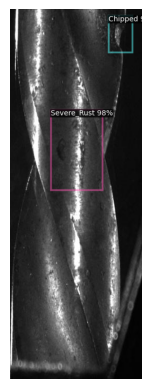

Saved: /home/coder/data/trong/KLTN/Unbiased_Teacher/inferences/S242_Image__2025-11-11__11-46-54_dark_4_crop_6_jpg.jpg


In [48]:
# === đường dẫn ảnh cần suy luận ===
img_path = "/home/coder/data/trong/KLTN/data_drill_3/test/S242_Image__2025-11-11__11-46-54_dark_4_crop_6_jpg.rf.3e996b0c7089ad0eb23837b1f658444a.jpg"

name_img_save =  img_path.split('.')[0].split('/')[-1]
im = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
if im is None:
    raise FileNotFoundError(img_path)

# Nếu ảnh là grayscale 1 kênh -> chuyển sang BGR 3 kênh
if im.ndim == 2:
    im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)

# === suy luận ===
outputs = predictor(im)  # dict: {"instances": Instances}
inst = outputs["instances"].to("cpu")

# Lấy kết quả thô
boxes  = inst.pred_boxes.tensor.numpy() if inst.has("pred_boxes") else np.empty((0,4))
classes= inst.pred_classes.numpy()      if inst.has("pred_classes") else np.empty((0,))
scores = inst.scores.numpy()            if inst.has("scores") else np.empty((0,))

print("Num detections:", len(boxes))
for i, (b, c, s) in enumerate(zip(boxes, classes, scores)):
    print(f"{i:02d}: cls={int(c)} score={s:.3f} box={b.tolist()}")

# === vẽ và lưu ảnh kết quả ===
vis = Visualizer(im[:, :, ::-1], metadata=meta, scale=1.0, instance_mode=ColorMode.SEGMENTATION)
out = vis.draw_instance_predictions(inst)
out_img = out.get_image()[:, :, ::-1]

save_path = os.path.join(os.path.dirname("/home/coder/data/trong/KLTN/Unbiased_Teacher/inferences/"), name_img_save + ".jpg")
cv2.imwrite(save_path, out_img)
plt.imshow(out_img[:,:,::-1])
plt.axis('off')
plt.show()
print("Saved:", save_path)

In [27]:
getattr(meta, "thing_classes", [])

['drill', 'Broken', 'Chipped', 'Scratched', 'Severe_Rust', 'Tip_Wear']

In [ ]:
# from detectron2.data.datasets import register_coco_instances
# from detectron2.data import DatasetCatalog
# import cv2, random
# import matplotlib.pyplot as plt
# from detectron2.utils.visualizer import Visualizer
# from ubteacher.engine.trainer import CustomPredictor

# register_coco_instances("TRAIN_DATASET", {}, "/home/coder/trong/KLTN_SEMI/data/train/_annotations.coco.json", "/home/coder/trong/KLTN_SEMI/data/train")
# register_coco_instances("VAL_DATASET", {}, "/home/coder/trong/KLTN_SEMI/data/valid/_annotations.coco.json", "/home/coder/trong/KLTN_SEMI/data/valid")

In [ ]:
# import os
# from detectron2.config import get_cfg

# cfg = get_cfg()

# cfg.merge_from_file("/home/coder/trong/KLTN_SEMI/code/Unbiased_Teacher/configs/Base-RCNN-FPN.yaml")
# cfg.MODEL.WEIGHTS = os.path.join("/home/coder/trong/KLTN_SEMI/code/Unbiased_Teacher/output/model_best.pth")
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.50   # Testing threshold
# cfg.DATASETS.TRAIN = ("TRAIN_DATASET", )
# cfg.DATASETS.TEST = ("VAL_DATASET", )


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



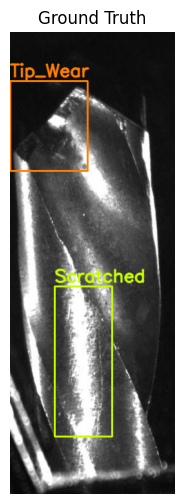

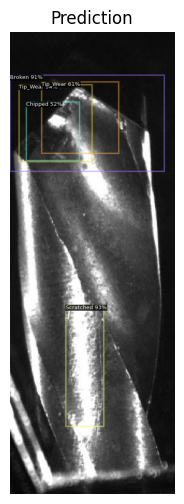

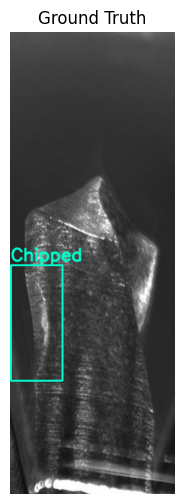

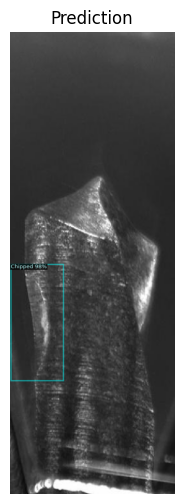

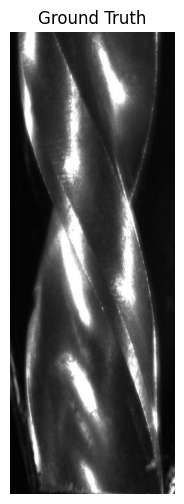

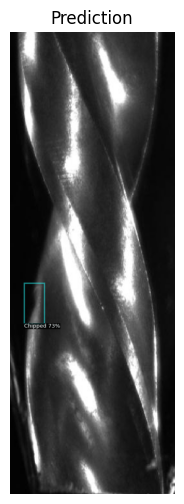

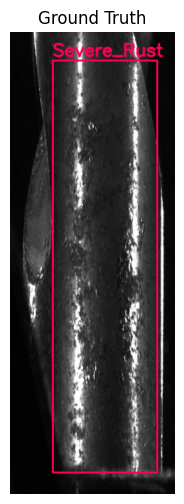

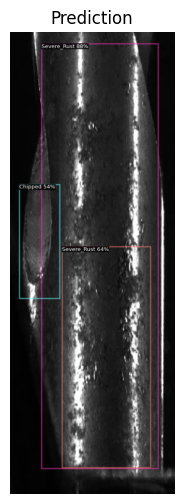

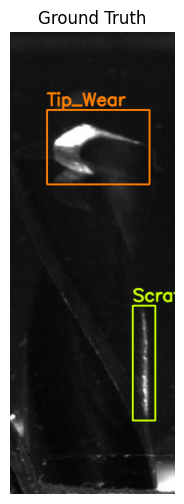

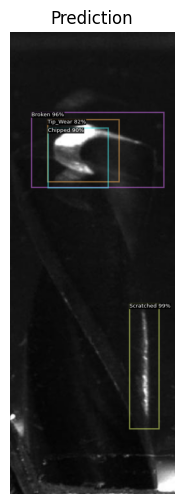

In [29]:
# Đặt bảng màu cố định (RGB 0-255) cho 6 lớp (đổi nếu bạn có số lớp khác)
import random
from detectron2.data import DatasetCatalog
# # Thứ tự colors sẽ được dùng chung cho cả prediction & ground-truth
meta.thing_colors = [
            (255, 255, 0),
            (134, 34, 255),   
            (0, 255, 206),
            (199, 252, 0), 
            (254, 0, 86), 
            (255, 128, 0), 
            
        ]
dataset_dicts = DatasetCatalog.get("VAL_DATASET")
class_names = getattr(meta, "thing_classes", [])
dataset_id_to_contig = getattr(meta, "thing_dataset_id_to_contiguous_id", None)

for d in random.sample(dataset_dicts, min(5, len(dataset_dicts))):
    im_bgr = cv2.imread(d["file_name"])
    outputs = predictor(im_bgr)

    # ===== Prediction: phóng to font bằng scale =====
    im_rgb = im_bgr[:, :, ::-1]
    v = Visualizer(im_rgb, metadata=meta, scale=1.6, instance_mode=ColorMode.SEGMENTATION)  # <-- chữ & nét to hơn
    vis_pred = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    pred_rgb = vis_pred.get_image()

    # ===== Ground-truth: tô bbox theo cùng màu class =====
    im_gt_bgr = im_bgr.copy()
    annotations = d.get("annotations", None)
    if annotations:
        for ann in annotations:
            # COCO: bbox = [x, y, w, h] (xywh)
            x, y, w, h = [int(v) for v in ann["bbox"]]
            ds_id = ann.get("category_id")

            # Lấy chỉ số class liên tục để index vào bảng màu & tên lớp
            if dataset_id_to_contig is not None and ds_id in dataset_id_to_contig:
                cid = dataset_id_to_contig[ds_id]
            else:
                cid = ds_id  # fallback (nếu đã contiguous sẵn)

            # Lấy màu RGB theo class rồi đổi sang BGR cho OpenCV
            rgb = meta.thing_colors[cid % len(meta.thing_colors)]
            bgr = (rgb[2], rgb[1], rgb[0])

            name = class_names[cid] if cid < len(class_names) else str(cid)

            # Vẽ bbox & tên lớp (font to hơn chút)
            cv2.rectangle(im_gt_bgr, (x, y), (x + w, y + h), bgr, 2)
            cv2.putText(im_gt_bgr, name, (x, max(0, y - 7)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, bgr, 2, lineType=cv2.LINE_AA)

    # Hiển thị GT với màu khớp class/predict
    plt.figure(figsize=(6, 6))
    plt.imshow(im_gt_bgr[:, :, ::-1])  # BGR -> RGB
    plt.title("Ground Truth"); plt.axis("off")
    plt.show()
    # Hiển thị prediction
    plt.figure(figsize=(6, 6))
    plt.imshow(pred_rgb)  # Visualizer trả RGB
    plt.title("Prediction"); plt.axis("off")
    plt.show()